## Imports

In [578]:
 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker


from pathlib import Path
from pdf2image import convert_from_path
import numpy as np
from PIL import Image

## Load and Preprocess Data

Here you are going to use the training and testing splits of the data. Testing split will be used for validation.

In [579]:
# utility to display a row of images with their predictions and true labels
def display_image(image, title):

  plt.figure(figsize=(15,5))
  plt.title(title)
  plt.yticks([])
  plt.grid(None)
  image = np.reshape(image, [3, 3509, 2481])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [3509, 2481*3])
  plt.imshow(image)

In [580]:
def load_images_and_labels(path, label):
    filename=[]
    images=[]
    labels = []

    folder_path = Path(path)
    pdf_files = [f.name for f in folder_path.glob("*.pdf")]

    for file in pdf_files:
        print(file)
        image = convert_from_path(path + file, dpi=75)
        image = np.array(image)
        # Convert RGB to grayscale (monochrome)
        if image.shape[-1] == 3:  # Ensure it's an RGB image
            image = tf.image.rgb_to_grayscale(image)
        image = tf.convert_to_tensor(image, dtype=tf.uint8) 

        # Set the target height and width (adjust as needed)
        target_size = (1241, 1000)  # Example target width and height

        # Resize all images
        image_resized = tf.image.resize(image, target_size)
        
        if image_resized.shape[0] == 1:
            filename.append(file)
            images.append(image_resized)
            
            #collect class code from dictionary
            labels.append(class_codes[label])
            #result[file] = {'image' : image, 'label' : label}
    result = tf.data.Dataset.from_tensor_slices({'filename' : filename,  "image": images, "label": labels})
    return result

def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]


In [581]:
#class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names = ["ECG_GCG", "ECG_FCG", "ECG_GCG_EC", "GCG_GCG_GCG"]
class_codes = {"ECG_GCG" : 0, "ECG_FCG" : 1, "ECG_GCG_EC" : 2, "GCG_GCG_GCG" : 3}

In [582]:
base_path = 'C:/Users/jonhe/OneDrive/Documents/Hackathons/AEC Construction 2025/'

# pdf_local_path = 'data/Wall_Slab/'

# pdf_full_path = base_path + pdf_local_path

In [583]:
# Convert PDF pages to a list of PIL images
#image = convert_from_path(pdf_full_path, dpi=75)  # Set dpi for resolution
label = 'ECG_GCG'
pdf_local_path = 'data/Wall_Slab/'
input1 = load_images_and_labels(path = pdf_local_path, label = label)

label = 'ECG_FCG'
pdf_local_path = 'data/ECG_FCG/'
input2 = load_images_and_labels(path = pdf_local_path, label = label)

label = 'ECG_GCG_EC'
pdf_local_path = 'data/ECG_GCG_EC/'
input3 = load_images_and_labels(path = pdf_local_path, label = label)

label = 'GCG_GCG_GCG'
pdf_local_path = 'data/GCG_GCG_GCG/'
input4 = load_images_and_labels(path = pdf_local_path, label = label)


# Concatenate them
fused_dataset = input1.concatenate(input2).concatenate(input3).concatenate(input4)

# # Print result
# for element in fused_dataset:
#     print(element.numpy())

# Output: 1 2 3 4 5 6


02.6.42 D35 Fenster Wohnen OG.pdf
02.6.43 D36 Fenster Bad OG.pdf
230523_Beispiel Standarddetail.pdf
hbu107-pages.pdf
hbu111-pages.pdf
HK1.05.pdf
HK1.06.pdf
HK1.08.pdf
HK1.11.pdf
HK1.13.pdf
MW1.07.pdf
WF1.12.pdf
WF1.13.pdf
WF1.14.pdf
WF1.17.pdf
WF1.18.pdf
WF1.19.pdf
WF1.23.pdf
WF1.24.pdf
WF2.01.pdf
WF2.03.pdf
WF2.04.pdf
WF2.05.pdf
WF3.01.pdf
02.6.61 D57 Vordach Ost (1).pdf
02.6.61 D57 Vordach Ost.pdf
02.6.62 D58 Vordach Süd (1).pdf
02.6.62 D58 Vordach Süd.pdf
0210.1.1.1-Schnitt Dachrand Südflügel.pdf
DF1.01.pdf
DF1.02.pdf
DF2.10.pdf
DF3.04.pdf
DF4.02.pdf
DR01.pdf
DR02.pdf
DR03.pdf
DR04.pdf
DR05.pdf
DR06.pdf
DR07.pdf
DR08.pdf
DR09.pdf
DR10.pdf
DR11.pdf
DR12.pdf
WEG-3-D-1201 Dachrandabschluss(V).pdf
Zinco_Dachrand begrünt.pdf
ZinCo_Dachrand Begrünung mit Attika.pdf
ZinCo_Dachrand Begrünung mit Kiesstreifen.pdf
ZinCo_Dachrand mit Wasserspeier.pdf
ZinCo_Dachrand niedrig mit Kiesstreifen.pdf
02.6.2 D02 Fassadenanschluss Untergeschoss.pdf
02.6.21 D20a Zuluftöffnung Wärmepumpe Technik.pdf
02.6

In [584]:
fused_dataset

<_ConcatenateDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(1, 1241, 1000, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int32, name=None)}>

In [585]:
# for sample in fused_dataset.take(50):  # Adjust the number of samples as needed
#     print(sample['label'].numpy())  # Convert from Tensor to NumPy


In [586]:
input_formatted = fused_dataset.map(format_image)

In [587]:
# plt.figure(figsize=(17,8))
# plt.imshow(image_arrays[0])

In [588]:
# Convert the NumPy array into a TensorFlow dataset
#dataset = tf.data.Dataset.from_tensor_slices({"image": image_arrays, "label": labels})

In [589]:
#tf_image_array = tf.data.Dataset.from_tensor_slices(image_arrays[0])

In [590]:
#train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
#test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=True)

Now you shuffle and batch your training and test datasets before feeding them to the model.

In [591]:
input_formatted = input_formatted.shuffle(buffer_size=1024)

In [592]:
# Example: Your dataset (assuming it's already created)
dataset = input_formatted  # Replace with your actual dataset

# Get dataset size (if unknown)
dataset_size = dataset.cardinality().numpy()
if dataset_size == tf.data.INFINITE_CARDINALITY:
    raise ValueError("Dataset size is infinite; cannot split.")
elif dataset_size == tf.data.UNKNOWN_CARDINALITY:
    dataset_size = sum(1 for _ in dataset)  # Count elements manually

# Define split ratio
train_ratio = 0.9
train_size = int(dataset_size * train_ratio)

# Split dataset
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Print dataset sizes
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {train_size}")
print(f"Test dataset size: {dataset_size - train_size}")

Total dataset size: 108
Train dataset size: 97
Test dataset size: 11


In [593]:
batch_size = 32
train = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test =  test_dataset.batch(batch_size=batch_size)

## Define the Model
You are using a simple model in this example. You use Keras Functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [594]:
def base_model():
  inputs = tf.keras.Input(shape=(1241000,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(4, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

## Define Optimizer and Loss Function

You have chosen `adam` optimizer and sparse categorical crossentropy loss for this example.

In [595]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000025)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics

You will also define metrics so that your training loop can update and display them. Here you are using `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.

In [596]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop
In this section you build your training loop consisting of training and validation sequences.

The core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case **sparse categorical crossentropy**) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [597]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

This function performs training during one epoch. You run through all batches of training data in each epoch to make updates to trainable weights using your previous function. You can see that we also call update_state on your metrics to accumulate the value of your metrics.
You are displaying a progress bar to indicate completion of training in each epoch. Here you use tqdm for displaying the progress bar.

In [598]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

At the end of each epoch you have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [599]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

Next you define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Combine the functions you built earlier to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.


In [600]:
for x_batch_train, y_batch_train in train.take(1):  # Take a single batch
    print(f"x_batch_train dtype: {x_batch_train.dtype}")
    print(f"y_batch_train dtype: {y_batch_train.dtype}")

x_batch_train dtype: <dtype: 'float32'>
y_batch_train dtype: <dtype: 'int32'>


In [601]:

model = base_model()

# Iterate over epochs.
epochs = 30
epochs_val_losses, epochs_train_losses = [], []
epochs_val_acc, epochs_train_acc = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()
  epochs_train_acc.append(train_acc)

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()
  epochs_val_acc.append(val_acc)

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  #print('\n Epoch %s: Train loss: %.4f , Train Accuracy: %.4f' % (epoch, float(losses_train_mean),  float(train_acc)))
  
  train_acc_metric.reset_state()
  val_acc_metric.reset_state()




Start of epoch 0


Training loss for step 3: 18.8736: 100%|██████████| 4/4 



 Epoch 0: Train loss: 14.7697  Validation Loss: 6.7951, Train Accuracy: 0.1856, Validation Accuracy 0.2727
Start of epoch 1


Training loss for step 3: 10.7834: 100%|██████████| 4/4 



 Epoch 1: Train loss: 8.1325  Validation Loss: 5.5660, Train Accuracy: 0.2577, Validation Accuracy 0.2727
Start of epoch 2


Training loss for step 3: 2.8732: 100%|██████████| 4/4 



 Epoch 2: Train loss: 3.6100  Validation Loss: 3.1174, Train Accuracy: 0.2784, Validation Accuracy 0.1818
Start of epoch 3


Training loss for step 3: 12.5575: 100%|██████████| 4/4 



 Epoch 3: Train loss: 5.9352  Validation Loss: 3.5685, Train Accuracy: 0.2474, Validation Accuracy 0.3636
Start of epoch 4


Training loss for step 3: 0.1240: 100%|██████████| 4/4 



 Epoch 4: Train loss: 2.0507  Validation Loss: 2.8369, Train Accuracy: 0.1959, Validation Accuracy 0.3636
Start of epoch 5


Training loss for step 3: 4.4003: 100%|██████████| 4/4 



 Epoch 5: Train loss: 3.3536  Validation Loss: 2.9603, Train Accuracy: 0.2784, Validation Accuracy 0.2727
Start of epoch 6


Training loss for step 3: 1.2014: 100%|██████████| 4/4 



 Epoch 6: Train loss: 3.4674  Validation Loss: 1.5895, Train Accuracy: 0.2268, Validation Accuracy 0.6364
Start of epoch 7


Training loss for step 3: 4.2613: 100%|██████████| 4/4 



 Epoch 7: Train loss: 4.4121  Validation Loss: 1.3643, Train Accuracy: 0.2371, Validation Accuracy 0.3636
Start of epoch 8


Training loss for step 3: 0.0160: 100%|██████████| 4/4 



 Epoch 8: Train loss: 2.8748  Validation Loss: 4.1837, Train Accuracy: 0.2474, Validation Accuracy 0.1818
Start of epoch 9


Training loss for step 3: 2.7833: 100%|██████████| 4/4 



 Epoch 9: Train loss: 3.4200  Validation Loss: 1.9755, Train Accuracy: 0.2680, Validation Accuracy 0.3636
Start of epoch 10


Training loss for step 3: 4.9258: 100%|██████████| 4/4 



 Epoch 10: Train loss: 3.2236  Validation Loss: 1.7073, Train Accuracy: 0.2784, Validation Accuracy 0.3636
Start of epoch 11


Training loss for step 3: 0.8185: 100%|██████████| 4/4 



 Epoch 11: Train loss: 2.3312  Validation Loss: 2.1854, Train Accuracy: 0.2680, Validation Accuracy 0.4545
Start of epoch 12


Training loss for step 3: 1.5745: 100%|██████████| 4/4 



 Epoch 12: Train loss: 2.0585  Validation Loss: 1.7186, Train Accuracy: 0.3299, Validation Accuracy 0.3636
Start of epoch 13


Training loss for step 3: 1.5604: 100%|██████████| 4/4 



 Epoch 13: Train loss: 1.7251  Validation Loss: 1.4861, Train Accuracy: 0.3196, Validation Accuracy 0.3636
Start of epoch 14


Training loss for step 3: 3.2231: 100%|██████████| 4/4 



 Epoch 14: Train loss: 2.4438  Validation Loss: 2.5139, Train Accuracy: 0.2474, Validation Accuracy 0.3636
Start of epoch 15


Training loss for step 3: 1.7906: 100%|██████████| 4/4 



 Epoch 15: Train loss: 1.8797  Validation Loss: 3.6668, Train Accuracy: 0.3196, Validation Accuracy 0.3636
Start of epoch 16


Training loss for step 3: 1.3005: 100%|██████████| 4/4 



 Epoch 16: Train loss: 2.6508  Validation Loss: 1.4831, Train Accuracy: 0.2990, Validation Accuracy 0.3636
Start of epoch 17


Training loss for step 3: 0.5015: 100%|██████████| 4/4 



 Epoch 17: Train loss: 1.5304  Validation Loss: 2.5780, Train Accuracy: 0.3608, Validation Accuracy 0.1818
Start of epoch 18


Training loss for step 3: 3.5901: 100%|██████████| 4/4 



 Epoch 18: Train loss: 2.3580  Validation Loss: 1.9299, Train Accuracy: 0.4433, Validation Accuracy 0.1818
Start of epoch 19


Training loss for step 3: 0.3161: 100%|██████████| 4/4 



 Epoch 19: Train loss: 1.6360  Validation Loss: 1.7853, Train Accuracy: 0.3299, Validation Accuracy 0.4545
Start of epoch 20


Training loss for step 3: 0.1859: 100%|██████████| 4/4 



 Epoch 20: Train loss: 1.6206  Validation Loss: 1.4340, Train Accuracy: 0.4124, Validation Accuracy 0.2727
Start of epoch 21


Training loss for step 3: 1.7980: 100%|██████████| 4/4 



 Epoch 21: Train loss: 1.7834  Validation Loss: 1.1438, Train Accuracy: 0.3093, Validation Accuracy 0.5455
Start of epoch 22


Training loss for step 3: 1.7903: 100%|██████████| 4/4 



 Epoch 22: Train loss: 1.2940  Validation Loss: 1.0954, Train Accuracy: 0.4433, Validation Accuracy 0.6364
Start of epoch 23


Training loss for step 3: 0.4949: 100%|██████████| 4/4 



 Epoch 23: Train loss: 1.1248  Validation Loss: 1.4400, Train Accuracy: 0.3505, Validation Accuracy 0.5455
Start of epoch 24


Training loss for step 3: 1.5817: 100%|██████████| 4/4 



 Epoch 24: Train loss: 1.4408  Validation Loss: 1.1148, Train Accuracy: 0.4639, Validation Accuracy 0.5455
Start of epoch 25


Training loss for step 3: 0.5979: 100%|██████████| 4/4 



 Epoch 25: Train loss: 1.1152  Validation Loss: 2.3016, Train Accuracy: 0.4742, Validation Accuracy 0.5455
Start of epoch 26


Training loss for step 3: 1.9655: 100%|██████████| 4/4 



 Epoch 26: Train loss: 1.6942  Validation Loss: 1.9678, Train Accuracy: 0.5567, Validation Accuracy 0.4545
Start of epoch 27


Training loss for step 3: 2.6525: 100%|██████████| 4/4 



 Epoch 27: Train loss: 2.1872  Validation Loss: 1.9571, Train Accuracy: 0.3918, Validation Accuracy 0.3636
Start of epoch 28


Training loss for step 3: 1.7686: 100%|██████████| 4/4 



 Epoch 28: Train loss: 1.6930  Validation Loss: 1.7792, Train Accuracy: 0.3299, Validation Accuracy 0.3636
Start of epoch 29


Training loss for step 3: 4.8962: 100%|██████████| 4/4 


 Epoch 29: Train loss: 2.4568  Validation Loss: 1.7028, Train Accuracy: 0.4433, Validation Accuracy 0.3636


## Evaluate Model

### Plots for Evaluation
You plot the progress of loss as training proceeds over number of epochs.

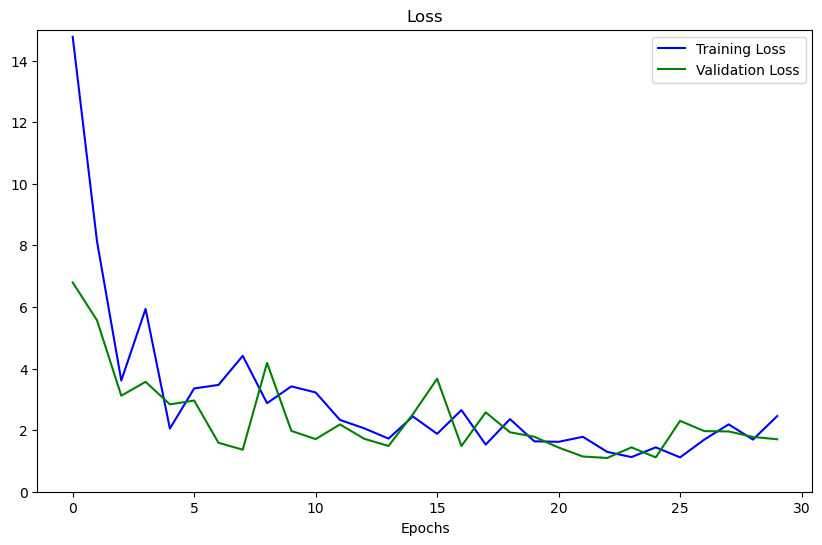

In [602]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
#ef plot_metrics(train_metric,  metric_name, title, ylim=50):
  plt.figure(figsize=(10, 6))
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlabel("Epochs")  # Add x-axis label
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
  plt.plot(train_metric,color='blue',label='Training ' + metric_name)
  plt.plot(val_metric,color='green',label='Validation ' + metric_name)
  plt.legend()
  

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=15.0)
#plot_metrics(epochs_train_losses,  "Loss", 'Loss', ylim=15.0)

This function displays a row of images with their predictions and true labels.

In [557]:
val_acc

<tf.Tensor: shape=(), dtype=float32, numpy=0.9090909361839294>

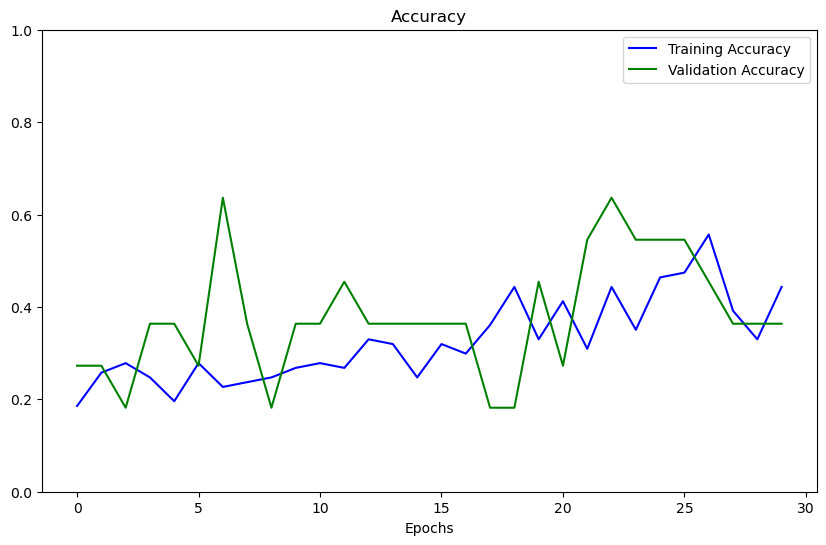

In [603]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
#ef plot_metrics(train_metric,  metric_name, title, ylim=50):
  plt.figure(figsize=(10, 6))
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlabel("Epochs")  # Add x-axis label
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))
  plt.plot(train_metric,color='blue',label='Training ' + metric_name)
  plt.plot(val_metric,color='green',label='Validation ' + metric_name)
  plt.legend()
  

plot_metrics(epochs_train_acc, epochs_val_acc, "Accuracy", "Accuracy", ylim=1.0)
#plot_metrics(epochs_train_losses,  "Loss", 'Loss', ylim=15.0)

In [484]:
model

<Functional name=functional_17, built=True>

In [554]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  # image = np.reshape(image, [n, 28, 28])
  # image = np.swapaxes(image, 0, 1)
  # image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

In [605]:
#Freeze and export model
for layer in model.layers:
    layer.trainable = False

model.trainable = False

model.save("model.keras")


You make predictions on the test dataset and plot the images with their true and predicted values.

In [ ]:
# test_inputs = train.batch(batch_size=1000001)
# x_batches, y_pred_batches, y_true_batches = [], [], []

# for x, y in test_inputs:
#   y_pred = model(x)
#   y_pred_batches = y_pred.numpy()
#   y_true_batches = y.numpy()
#   x_batches = x.numpy()

# indexes = np.random.choice(len(y_pred_batches), size=10)
# images_to_plot = x_batches[indexes]
# y_pred_to_plot = y_pred_batches[indexes]
# y_true_to_plot = y_true_batches[indexes]

# y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
# y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
# display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)

ValueError: Inputs to a layer should be tensors. Got 'image' (of type <class 'str'>) as input for layer 'functional_17'.